In [515]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.integrate import solve_ivp

In [516]:
# Conventions

# y is a vector containing the abundance (or relative) of all the gases we want to track.
# y_0 = nCO
# y_1 = xH2 (nuclei ratio, =2*nH2/nH_nuclei)

In [517]:
# Functions

# The ODE
def NL97(y, t, k0, nC, n0, beta, gammaCO, k_coll_e, k_coll_HI, k_coll_He, k_coll_H2, xe, xHe, k_UV, k_LW):
    '''
    Compute dy/dt, the derivative, in the NL97 equation.
    Inputs:
    * t: Time, doesn't matter here, just to make it compatible with scipy solve_ivp.
    * y: The number densities of CO and H2.
    * k0: The rate coefficient for the formation of CHx.
    * nC: The number density of C+ ions.
    * n0: The number density of everything., mostly hydrogen atoms.
    * beta: The proportion of CHx that successfully forms CO.
    * gammaCO: The photodissociation rate of CO
    * k_coll_e: The collisional dissociation rate of e-, as given in Table A1 8-11 of Gloevr & Abel 2008.
    * k_coll_HI: The collisional dissociation rate of H.
    * k_coll_He: The collisional dissociation rate of He.
    * k_coll_H2: The collisional dissociation rate of H2.
    * xe: Relative abundance of e-
    * xHe: Relative abundance of He
    * k_UV: UV photoionization and photodissociation rate
    * k_LW: Lyman-Werner photoionization and photodissociation rate
    * R_d: Formation rate of H2 on dust.
    
    Outputs:
    * dydt: The time derivative of the vector y.
    '''
    
    # Extract the abundances from the array y
    nCO = y[0]
    xH2 = y[1]
    
    # Calculate the derivative
    nH2 = n0 * xH2
    xHI = 1 - xH2
    dy0dt = k0*nC*nH2*beta - gammaCO*nCO
    
    ne = n0 * xe
    nHI = n0 * xHI
    nHe = n0 * xHe
    C_coll = k_coll_e*ne + k_coll_HI*nHI + k_coll_He*nHe + k_coll_H2*nH2 
    dy1dt = -C_coll*xH2 - (k_UV+k_LW)*xH2 + R_d*nHI
    
    # Return
    dydt = np.array([dy0dt, dy1dt])
    return dydt

# The construction part of the ODE
def NL97_c(y, t, k0, nC, n0, beta, gammaCO, k_coll_e, k_coll_HI, k_coll_He, k_coll_H2, xe, xHe, k_UV, k_LW):
    '''
    Compute the construction rate in the NL97 equation. See the docstring for NL97.
    '''
    
    # Extract the abundances from the array y
    nCO = y[0]
    xH2 = y[1]
    
    # Calculate the derivative
    nH2 = n0 * xH2
    xHI = 1 - xH2
    dy0dt = k0*nC*nH2*beta
    
    ne = n0 * xe
    nHI = n0 * xHI
    nHe = n0 * xHe
    C_coll = k_coll_e*ne + k_coll_HI*nHI + k_coll_He*nHe + k_coll_H2*nH2 
    dy1dt = R_d*nHI
    
    # Return
    dydt_c = np.array([dy0dt, dy1dt])
    return dydt_c

# The destruction part of the ODE, DIVIDED BY Y
def NL97_d(y, t, k0, nC, n0, beta, gammaCO, k_coll_e, k_coll_HI, k_coll_He, k_coll_H2, xe, xHe, k_UV, k_LW):
    '''
    Compute the destruction rate in the NL97 equation, DIVIDED BY Y. See the docstring for NL97.
    '''
    
    # Extract the abundances from the array y
    nCO = y[0]
    xH2 = y[1]
    
    # Calculate the derivative
    nH2 = n0 * xH2
    xHI = 1 - xH2
    dy0dt = gammaCO # Absolute value, same below
    
    ne = n0 * xe
    nHI = n0 * xHI
    nHe = n0 * xHe
    C_coll = k_coll_e*ne + k_coll_HI*nHI + k_coll_He*nHe + k_coll_H2*nH2 
    dy1dt = C_coll + (k_UV+k_LW)
    
    # Return
    dydt_d = np.array([dy0dt, dy1dt])
    return dydt_d

# One Step of explicit ODE Solver
def ode_solve_step_explicit(f, y0, t, dt):
    '''
    One step in solving the ODE problem, i.e. dy/dt = f(y,t), explicitly.
    Input:
    * f: a function that receives the current state, y, and the current position/time, t,
    and returns the derivative value of the state, dy/dt.
    * y0: The current value as an array.
    * t: The current time.
    * dt: The time interval to be stepped through.
    
    Output:
    * yf: The final value at t+dt.
    '''
    
    # Step through the most basic algorithm
    yf = y0 + f(y0,t)*dt
    
    # Return
    print (f(y0,t))
    return yf

# One Step of semi-implicit ODE Solver
def ode_solve_step_semi_implicit(fc, fd, y0, t, dt):
    '''
    One step in solving the ODE problem, i.e. dy/dt = f(y,t), semi-implicitly, using the algorithm in eq. (3) in RAMSES-RTZ.
    Input:
    * fc: The creation part of dydt.
    * fd: The destruction part of dydt.
    * y0: The current value as an array.
    * t: The current time.
    * dt: The time interval to be stepped through.
    
    Output:
    * yf: The final value at t+dt.
    '''
    
    # Step through the semi-implicit algorithm
    yf = (y0 + fc(y0,t)*dt) / (np.full_like(y0, 1) + fd(y0,t)*dt)
    
    # Return
    return yf
    
# ODE Solver
def ode_solve(f, fc, fd, y0, t, method):
    '''
    Solve the ODE problem, i.e. dy/dt = f(y,t).
    Input:
    * f: a function that receives the current state, y, and the current position/time, t,
    and returns the derivative value of the state, dy/dt.
    * fc: The creation part of dydt. None if not applicable.
    * fd: The destruction part of dydt. None if not applicable.
    * y0: The initial value.
    * t: numpy array of time steps with length N where the values of y will be returned.
    * method: The method of integration. Choices:
        'explicit': The most basic algorithm.
        'semi-implicit': The semi-implicit method in RAMSES-RTZ.
    
    Output:
    * y: (M x N) numpy array that contains the values of y at every position/time step. Different columns are different times.
    '''
    
    num_times = t.shape[0] # The dimension of vector t
    num_vars = y0.shape[0] # The number of variables in question
    y = np.zeros((num_vars, num_times))
    y[:, 0] = y0 # Set y at time 0 as y0
    
    # Make the calculation
    if (method == 'explicit'):   
        for i in np.arange(num_times - 1):
            y[:, i+1] = ode_solve_step_explicit(f, y[:, i], t[i], t[i+1] - t[i])
    elif (method == 'semi-implicit'):   
        for i in np.arange(num_times - 1):
            y[:, i+1] = ode_solve_step_semi_implicit(fc, fd, y[:, i], t[i], t[i+1] - t[i])
            
    # Return
    return y

# Convert from seconds to Myr
def sec_to_Myr(t):
    '''
    Convert from seconds to Myr.
    Input:
    * t: Numpy array of times in seconds.
    
    Output:
    * t_Myr: Numpy array of times in Myr.
    '''
    
    return t / 1e6 / 365 / 86400

In [518]:
# Inputs
k0 = 5e-16 # cm^3 s^-1
n0 = 100 # Initial number density of hydrogen nuclei
AV = 3.3 # Mean extinction, 3.3 for n0=100
xC = 1.41e-4 # Relative abundance to hydrogen of carbon
xO = 3.16e-4 # Relative abundance to hydrogen of oxygen
# xH2 = 1 # Relative abundance to hydrogen nuclei of molecular hydrogen nuclei
k1 = 5e-10 # Rate coefficient for the formation of CO from O + CHx
G0 = 1.7 # The strength of the ultraviolet radiation field in units of the Habing field
T = 300 # Temperature
xe = 1e-4 # Relative abundance of e-
# xHI = 1 # Relative abundance of H
xHe = 1e-4 # Relative abundance of He
k_UV = 1e-14 # UV photoionization and photodissociation rate
k_LW = 1e-14 # Lyman-Werner photoionization and photodissociation rate
Z = 1 # Metallicity of the gas
C_f = 10 # Clumping factor

# Derived quantities
n = n0 # Assume the number density of hydrogen doesn't change
gammaCHx = 5e-10 * G0 * np.exp(-2.5*AV)
gammaCO = 1e-10 * G0 * np.exp(-2.5*AV)
beta = k1*xO / (k1*xO + gammaCHx / n)
nC = n0 * xC
# nH2 = n0 * xH2
k_coll_e = 4.49e-9 * T**0.11 * np.exp(-101858/T) # k_coll_e-: The collisional dissociation rate of e-, as given in Table A1 8-11 of Gloevr & Abel 2008.
k_coll_HI = 6.67e-12 * T**0.5 * np.exp(-(1+63593/T))# k_coll_HI: The collisional dissociation rate of H.
k_coll_He = 10**(-27.029 + 3.801*np.log10(T) - 29487/T) # k_coll_He: The collisional dissociation rate of He.
k_coll_H2 = 5.996e-30 * T**4.1881 / (1+6.761e-6*T)**5.6881 * np.exp(-54657.4/T) # k_coll_H2: The collisional dissociation rate of H2.
R_d = 3.5e-17 * Z * C_f # Formation of H2 on dust

# Solver parameters
n = 1000 # Number of steps
dt_Myr = 0.01 # Step size in Myr

In [519]:
gammaCO

4.4413954741283484e-14

In [520]:
beta

0.9861397574194282

In [521]:
# Run the explicit solver
dt = dt_Myr * 1e6 * 365 * 86400 # Time in seconds
t0 = 0 # Initial time
tf = t0 + n * dt # Final time
y0 = np.array([0,0]) # Initial abundances (or relative ~)
t = np.linspace(t0, tf, n+1) # Generate the times to report y values
dydt = lambda y, t : NL97(y, t, k0, nC, n0, beta, gammaCO, k_coll_e, k_coll_HI, k_coll_He, k_coll_H2, xe, xHe, k_UV, k_LW)
y = ode_solve(dydt, None, None, y0, t, 'explicit')
t_Myr = sec_to_Myr(t)

[0.0e+00 3.5e-14]
[7.67365441e-18 3.43929320e-14]
[1.51067307e-17 3.37963935e-14]
[2.23049070e-17 3.32102018e-14]
[2.92737419e-17 3.26341775e-14]
[3.60186769e-17 3.20681442e-14]
[4.25450385e-17 3.15119287e-14]
[4.88580406e-17 3.09653606e-14]
[5.49627868e-17 3.04282726e-14]
[6.08642725e-17 2.99005003e-14]
[6.65673871e-17 2.93818821e-14]
[7.20769161e-17 2.88722592e-14]
[7.73975430e-17 2.83714756e-14]
[8.25338518e-17 2.78793781e-14]
[8.74903284e-17 2.73958158e-14]
[9.22713630e-17 2.69206409e-14]
[9.68812518e-17 2.64537078e-14]
[1.01324199e-16 2.59948735e-14]
[1.05604318e-16 2.55439976e-14]
[1.09725635e-16 2.51009421e-14]
[1.13692089e-16 2.46655712e-14]
[1.17507533e-16 2.42377518e-14]
[1.21175738e-16 2.38173529e-14]
[1.24700393e-16 2.34042457e-14]
[1.28085109e-16 2.29983037e-14]
[1.31333415e-16 2.25994027e-14]
[1.34448766e-16 2.22074206e-14]
[1.37434541e-16 2.18222373e-14]
[1.40294046e-16 2.14437350e-14]
[1.43030514e-16 2.10717977e-14]
[1.45647107e-16 2.07063116e-14]
[1.48146920e-16 2.0347

In [522]:
# Run the scipy ODE solver using rk45
dydt_scipy = lambda t, y: dydt(y, t) # Swap variables just to make it compatible with scipy's ODE solver
y_scipy = solve_ivp(dydt_scipy, [t0, tf], y0, t_eval=t).y

In [523]:
# Run the semi-implicit solver
dydt_c = lambda y, t : NL97_c(y, t, k0, nC, n0, beta, gammaCO, k_coll_e, k_coll_HI, k_coll_He, k_coll_H2, xe, xHe, k_UV, k_LW)
dydt_d = lambda y, t : NL97_d(y, t, k0, nC, n0, beta, gammaCO, k_coll_e, k_coll_HI, k_coll_He, k_coll_H2, xe, xHe, k_UV, k_LW)
y_semi = ode_solve(dydt, dydt_c, dydt_d, y0, t, 'semi-implicit')
t_Myr = sec_to_Myr(t)

[0.00000000e+00 0.00000000e+00 2.41996366e-06 ... 9.96120333e-03
 9.96120387e-03 9.96120440e-03]


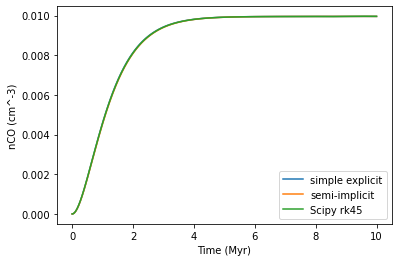

In [524]:
# Plot nCO vs. t using the explicit method
fig_nCO, ax_nCO = plt.subplots()
y_line, = ax_nCO.plot(t_Myr, y[0,:])
ax_nCO.set_xlabel('Time (Myr)')
ax_nCO.set_ylabel('nCO (cm^-3)')

# Plot nCO vs. t using the semi-implicit method
y_semi_line, = ax_nCO.plot(t_Myr, y_semi[0,:])

# Plot nCO vs. t again using scipy
y_scipy_line, = ax_nCO.plot(t_Myr, y_scipy[0,:])
print(y[0,:])

# Add legend
ax_nCO.legend([y_line, y_semi_line, y_scipy_line], ['simple explicit', 'semi-implicit', 'Scipy rk45'])

[0.00000000e+00 0.00000000e+00 2.41996366e-06 ... 9.96120333e-03
 9.96120387e-03 9.96120440e-03]


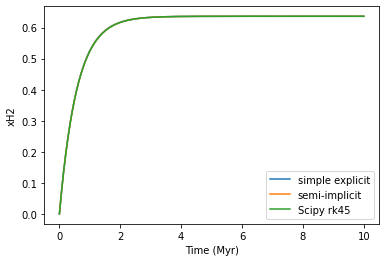

In [525]:
# Plot xH2 vs. t using the explicit method
fig_xH2, ax_xH2 = plt.subplots()
y_line, = ax_xH2.plot(t_Myr, y[1,:])
ax_xH2.set_xlabel('Time (Myr)')
ax_xH2.set_ylabel('xH2')

# Plot xH2 vs. t using the semi-implicit method
y_semi_line, = ax_xH2.plot(t_Myr, y_semi[1,:])

# Plot xH2 vs. t again using scipy
y_scipy_line, = ax_xH2.plot(t_Myr, y_scipy[1,:])
print(y[0,:])

# Add legend
ax_xH2.legend([y_line, y_semi_line, y_scipy_line], ['simple explicit', 'semi-implicit', 'Scipy rk45'])

In [526]:
# Save the graphs as pdfs
pp = PdfPages('CO Chemistry.pdf')
pp.savefig(fig_nCO)
pp.savefig(fig_xH2)
pp.close()

In [527]:
y_semi

array([[0.00000000e+00, 0.00000000e+00, 2.37157888e-06, ...,
        9.96119629e-03, 9.96119692e-03, 9.96119754e-03],
       [0.00000000e+00, 1.09684200e-02, 2.17477873e-02, ...,
        6.36363618e-01, 6.36363618e-01, 6.36363618e-01]])

In [528]:
y

array([[0.00000000e+00, 0.00000000e+00, 2.41996366e-06, ...,
        9.96120333e-03, 9.96120387e-03, 9.96120440e-03],
       [0.00000000e+00, 1.10376000e-02, 2.18837550e-02, ...,
        6.36363620e-01, 6.36363620e-01, 6.36363620e-01]])

In [529]:
y_scipy

array([[0.00000000e+00, 1.19740899e-06, 4.73994924e-06, ...,
        9.96538039e-03, 9.96530380e-03, 9.96522859e-03],
       [0.00000000e+00, 1.09424286e-02, 2.16966995e-02, ...,
        6.36275375e-01, 6.36276892e-01, 6.36278384e-01]])

In [530]:
y_scipy[0,500]

0.009922309221988414

In [531]:
y[0,500]

0.009923103892406315

In [532]:
y_semi[0,500]

0.009920123137369133